# Cis-activation and cis-inhibition model

**Background**: Nandagopal et al. 2019 came up with a model in the cis activation paper that enabled cis activation and inhibition to some extent. However, their model only considered interconversion between active and inactive cis complexes, without biological justification. In my model, I allow free receptor and ligand to either form active or inactive complexes, and active and inactive cannot directly interconvert without dissociation.

![Cis Notch Model](cis_model_schematic.png)

# Note: the k values above take different values for $C^-$ formation vs. $C^+$, corresponding to distinct $K_d$ values in the code below.

### Variables:

- $R$ is surface receptor concentration at cell interface
- $N$ is activated receptor (NICD) concentration
- $L$ is surface ligand concentration
- $C^+$ = $R:L$, trans-like receptor-ligand complex
- $C^-$ = $R:L$, true 'cis' receptor-ligand complex
- $i$ is index of receptor. $i = \{1, 2, 3\}$ for receptor = {Notch1, Notch2, Notch3}.
- $j$ is index of ligand. $j = \{1, 2, 3, 4\}$ for ligand = {Dll1, Dll4, Jag1, Jag2}.

### Parameters

- $\alpha_L$, surface ligand production rate
- $\alpha_R$, surface receptor production rate
- $\gamma_L$, surface ligand endocytosis rate (unstimulated)
- $\gamma_R$, is surface receptor endocytosis rate
- $\gamma_C$, endocytosis rate of true cis receptor-ligand complexes ($C^-$)
- $\gamma_T$, surface ligand endocytosis rate (stimulated) - receptor activating
- $\gamma_{N}$, activated receptor degradation rate (known! ~75 min)
- $d_R$, rate of leaky (ligand-independent) receptor activation
- $K_d$, **relative** equilibrium dissociation constant

## ODEs and other equations

\begin{align}
L_{tot} = L_{t_{tot}} + L_{c_{tot}}; L_{tot} = L_c + L_t + C^+ + C^-; R_{tot} = R + C^+ + C^-
\end{align}

\begin{align}
\frac{dL_{tot}}{dt} = \alpha_L - \gamma_{L} (L_{tot} - C^+ - C^-) - \gamma_R C^+ - \gamma_C C^- - \gamma_T C^+ 
\end{align}

\begin{align}
\frac{dR_{tot}}{dt} = \alpha_R - \gamma_{R} (R_{tot} - C^-) - \gamma_C C^- - \gamma_T C^+  
\end{align}

\begin{align}
\frac{dN}{dt} =  \gamma_T C^+ - \gamma_{N} N
\end{align}

With leaky activation:

\begin{align}
\frac{dL_{tot}}{dt} = \alpha_L - \gamma_{L} (L_{tot} - C^+ - C^-) - \gamma_R C^+ - \gamma_C C^- - \gamma_T C^+ 
\end{align}

\begin{align}
\frac{dR_{tot}}{dt} = \alpha_R - \gamma_{R} (R_{tot} - C^-) - \gamma_C C^- - \gamma_T C^+ - d_R (R_{tot} - C^- - C^+)
\end{align}

\begin{align}
\frac{dN}{dt} =  \gamma_T C^+ - \gamma_{N} N + d_R (R_{tot} - C^- - C^+)
\end{align}

EQTK can be used to compute equilibrium concentrations promiscuously binding species, but it can't be used to compute equilibrium concentrations of just two species that can bind in two different orientations to form two distinct 'types' of complexes. Thus, we must find a work-around to solve for $C^+$ and $C^-$ using EQTK.

**Ideas:**
1. Free ligand can exist in one of two 'conformations' which we can think of as distinct molecular species or states: the 'trans' state and the 'cis' state. Biophysically, the true ligand structure is identical in each of these cases, and what is really different is the membrane topology--this works if we think of each protein species as a complex of ligand and membrane. 
    - I think we can then determine how much $L_t$ and $L_c$ ligand we have using a probabilistic model.
    - This allows us to use EQTK to represent the formation of $C^+$ and $C^-$.
\begin{align}
R + L_t \rightleftharpoons C^+ \overset{\gamma_T}{\rightarrow} N
\end{align}

\begin{align}
C^+ \overset{\gamma_R}{\rightarrow} Ø
\end{align}

\begin{align}
R + L_c \rightleftharpoons C^- \overset{\gamma_C}{\rightarrow} Ø
\end{align}

\begin{align}
L_c \rightleftharpoons L_t
\end{align}

Then this is the only change to the above equations:

\begin{align}
L_{tot} = L_c + L_t + C^+ + C^-
\end{align}

We can then solve for $C^+$ and $C^-$ using EQTK.

### Non-dimensionalization

All concentration variables are relative to $K_d$. This works out so that the production rates ($\alpha$) are also ratios of true production rate over $K_d$. 



In [1]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.integrate
import numba
import eqtk
import pandas as pd

# # For interactive plots
# import ipywidgets

# Import plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
# Set matplotlib rc params.
rc = {'lines.linewidth' : 2, 'axes.labelsize' : 20, 'legend.fontsize': 12,
        'axes.titlesize' : 25, 'xtick.labelsize': 15, 'ytick.labelsize': 15}

sns.set(rc=rc)
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
def assess_steady_state_convergence(RLN, interval, convergence_crit):
    """Determines whether the system has reached
    steady-state."""
    
    converged = True
    
    # Compute gradient across last hour and compute percent difference
    
    back_idx = int(60 / interval + 1)
    
    # initialize
    (R_err, L_err, N_err) = (0.0, 0.0, 0.0)
    
    # Replace values while avoiding divide by zero errors
    # Multiply by 100 to get percent difference
    if RLN[-1,0] != 0:
        R_err = 100 * abs(RLN[-1,0] - RLN[-back_idx,0]) / RLN[-1,0]
    if RLN[-1,1] != 0:
        L1_err = 100 * abs(RLN[-1,1] - RLN[-back_idx,1]) / RLN[-1,1]
    if RLN[-1,2] != 0:
        L2_err = 100 * abs(RLN[-1,2] - RLN[-back_idx,2]) / RLN[-1,2]
    
    RLN_err = np.array((R_err, L_err, N_err))
    
    # Evaluate convergence   
    failed_arr = RLN_err > convergence_crit
    
    if np.sum(failed_arr) > 0:
#         print('The system has not reached steady state.')
        
        converged = False
        
    return converged

In [3]:
def solve_EQTK(c0_vect, stoich, K_vect):
    '''Takes in:
    - c0_vect = initial concentrations of all species in proper order
    - stoichiometric matrix
    - K_vect = list of Kd values in proper order '''

    N = stoich
    
    c = eqtk.solve(c0_vect, N, K_vect, units=None)
    
    R, Lt, Lc, C_plus, C_minus = c #all of the steady state concentrations after equilibrium is reached 
    
    # Sanity check of mass conservation:
    Rtot = c0_vect[0]
         
    return c

In [4]:
def plot_dynamics(t, y_vals, normalized=False, 
                  normalize_to_max=True, leg_loc='center right', 
                  leg_lab = ('Total receptor','Total ligand',
                             'Activated receptor','Trans R:L complex'),
                  xlab = 'time (hr)', ylim = False,
                  ylab = 'dimensionless conc.', title = '',
                 filesave = 'NA'):
    """Convenient plotting function for results"""
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    
    # Get plot of stimulus dynamics

    if normalized:
        ylab = 'normalized ' + ylab
        if normalize_to_max:
            ax = plt.plot(t, y_vals[:,0]/y_vals[:,0].max())
            ax = plt.plot(t, y_vals[:,1]/y_vals[:,1].max())
            ax = plt.plot(t, y_vals[:,2]/y_vals[:,2].max())
            if np.shape(y_vals)[1] > 3:
                ax = plt.plot(t, y_vals[:,3]/y_vals[:,3].max())
            if np.shape(y_vals)[1] > 4:
                ax = plt.plot(t, y_vals[:,4]/y_vals[:,4].max())

        else:
            ax = plt.plot(t, y_vals[:,0]/y_vals[-1,0])
            ax = plt.plot(t, y_vals[:,1]/y_vals[-1,1])
            ax = plt.plot(t, y_vals[:,2]/y_vals[-1,2])
            if np.shape(y_vals)[1] > 3:
                ax = plt.plot(t, y_vals[:,3]/y_vals[-1,3])
            if np.shape(y_vals)[1] > 4:
                ax = plt.plot(t, y_vals[:,4]/y_vals[-1,4])

    else:
        ax = plt.plot(t, y_vals[:,0])
        ax = plt.plot(t, y_vals[:,1])
        ax = plt.plot(t, y_vals[:,2])
        if np.shape(y_vals)[1] > 3:
            ax = plt.plot(t, y_vals[:,3])
        if np.shape(y_vals)[1] > 4:
            ax = plt.plot(t, y_vals[:,4])

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if ylim != False:
        plt.ylim(ylim)
    plt.legend(leg_lab,loc=leg_loc, fontsize = 14)
    plt.title(title, size=22)
    
    if filesave != 'NA':
        print('image saved.')
        filename =  '/Users/catherineko/Desktop/FSRI/Research/temp/' + filesave +  '.pdf'
        plt.savefig(filename, bbox_inches='tight', format='pdf')
    
    return ax

In [5]:
def get_steady_state_vals(RLN, interval, convergence_crit):
    '''Extracts steady-state values from end
    of simulation and reports percent difference 
    across last hour of simulation to assist 
    evaluation of whether steady-state was reached.
    Convergence criterion is the maximum percent
    difference allowed before we say the system has 
    reached steady-state. E.g. 1 for one percent.'''
    
    # Compute steady state vals
    
    R0 = RLN[-1,0]
    L0 = RLN[-1,1]
    N0 = RLN[-1,2]
    
    RLN0 = np.array((R0, L0, N0)) 
    
    # Determine whether system has reached steady-state
    
    converged = assess_steady_state_convergence(RLN, interval, convergence_crit)
    
    if converged:
        return RLN0
    else:
        return np.array((np.nan, np.nan, np.nan))

In [6]:
def concat_initial_value(RLN, RLN_initial, hr, tpts):
    """Adds on initial value to simulation output
    in order to see how 'mixing' senders and receivers
    altered receptor and ligand levels.
    Can take RLN or RLNT of any shape as long as the
    dimensions of RLN and RLN_initial are compatible."""
    
    # concat on initial values
    RLN = np.concatenate((RLN_initial, RLN), axis = 0)
    
    # update t accordingly:
    t = np.linspace(0, hr + (hr/tpts), tpts+1)
    
    return RLN, t

In [7]:
def compute_cis_activation_potency(N_vect): #peak over leaky 
    '''This function returns the peak activation
    over leaky activation (latter assumed to be first 
    N-value).'''
    
    return np.around(np.max(N_vect) / N_vect[0], decimals = 2)

def compute_cis_inhibition_potency(N_vect):#??? metric of cis inhibition
    '''This function returns the inhibitory potential,
    defined as how close to 'leaky' activation the inhibitory
    ligand dampens the signal.
    This is expressed as a fraction, where 1 is the maximal
    inhibition possible, and 0 = no inhibition.'''
    
    # (peak activation - activation at highest cis ligand level) / 
    # (peak activation - leaky activation)
    
    cis_inh = 100 * (np.max(N_vect) - N_vect[-1]) / (np.max(N_vect) - N_vect[0])
    
    return np.around(cis_inh, decimals = 2)


In [8]:
def titrate_ligand(aL_vect, params, hr, interval, convergence_crit):
    '''This runs a series of simulations to calculate
    steady-state N (NICD) values for a range of ligand 
    levels.
    aL_vect is the range of ligand values to explore'''
    
    N_vect = []
    
    for aL in aL_vect:
        
        Kd_t, Kd_c, aR, gR, dR, gT, aL_prev, gL, gC, gN = params
        params = Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN
        
        # Simulate
        RLN_initial, RLN, t = simulate_Notch_signaling(params, hr, interval)
        
        # get steady state value
        RLN0 = get_steady_state_vals(RLN, interval, convergence_crit)
        N = RLN0[2]
        
        N_vect.append(N)
        
    # Determine cis-activation potency
    cis_act = compute_cis_activation_potency(N_vect)
    
    # Determine cis-inhibition potency???
    cis_inh = compute_cis_inhibition_potency(N_vect)
        
    return np.array(N_vect), cis_act, cis_inh
    

In [9]:
def logistic(x, max_Lt_frac, inflection_pt, curvature):
    """Returns y value of logistic function at 
    x value(s) provided based on three curve parameters."""

    return max_Lt_frac / (1 + np.exp(curvature * (x - inflection_pt)))

Text(0.5, 0, '$C^-$')

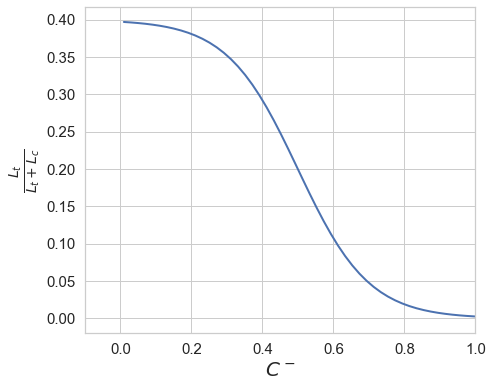

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# x = np.around(np.logspace(1.5, 3.4, num=100, base=10.0), decimals=4)
x = np.linspace(0.01,2, num=100)

inflection_pt = .5

plt.plot(x, logistic(x, .4, inflection_pt, 5 * (1/inflection_pt)))
# plt.xscale('log')
# plt.ylim(0,.42)
plt.xlim(-.1,inflection_pt * 2)
# plt.ylabel("$L_t$ / ($L_t$ + $L_c$)")
plt.ylabel("$\\frac{L_t}{L_t + L_c}$")
plt.xlabel("$C^-$")

In [11]:
def populate_ligand_states(L, C_minus_prev):
    """Computes fraction of free ligand (including protein
    and membrane state) that exists in trans-like vs. cis-
    like state (Lt vs Lc, respectively). This fraction 
    is computed based on a logistic function defined by
    three parameters that you must pass it.
    Returns Lt_tot, Lc_tot."""
    
    max_Lt_frac = 0.4 # 40%
    inflection_pt = .05 # TEMPORARY! MUST CHANGE
    curvature = 5 * (1/inflection_pt) # try 5 * 
    
    frac_Lt = logistic(C_minus_prev, max_Lt_frac, inflection_pt, curvature)
    
    Lt = frac_Lt * L
    Lc = (1 - frac_Lt) * L
    
    return Lt, Lc
    
    # I like the idea of sampling from a binomial distribution, 
    # where theta is returned by the logistic function,
    # but I think it's unnecessarily complicated.
    
    

In [12]:
#ODES
def dN_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of activated receptor (ICD); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return gT * C_p + dR * Rfree - gN * N


def dR_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of surface receptor (total receptor); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return aR - gR * (R - C_m) - gC * C_m - gT * C_p - dR * Rfree


def dL_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of surface ligand (total ligand); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return aL - gL * (Lt_free + Lc_free) - gR * C_p - gC * C_m - gT * C_p


In [13]:
def get_equilibrium_concentrations(R, Lt, Lc, circuit_params):
    """Gathers info needed to call EQTK
    and calls EQTK."""
    
    # Unpack params
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    
    # Stoichiometry matrix
    N_1_2 = [[1,  1,  0, -1,  0], #(1)R + (1)L_t + (0)L_c ⇌ (-1)C^+ + (0)C^-
         [1,  0,  1,  0, -1]] #(1)R + (0)L_t + (1)L_c ⇌ (0)C^+ + (-1)C^-
    
    # Array of Kd values
    K_vect = [Kd_t, Kd_c]

    # Initial concentration vector to pass to EQTK
    c0_vect = np.array((R, Lt, Lc, 0.0, 0.0)) # R_tot, Lt_tot, Lc_tot, C_plus, C_minus
    if np.isnan(c0_vect).any():
        print(c0_vect)
    neg = c0_vect[c0_vect < 0]
    if len(neg) > 0:
        print('negative found:', c0_vect)
        
    # Compute T based on R_tot and L_tot using EQTK
    Rfree, Lt_free, Lc_free, C_plus, C_minus = solve_EQTK(c0_vect, N_1_2, K_vect)
        
    return np.array([Rfree, Lt_free, Lc_free, C_plus, C_minus])

In [14]:
def Euler_integration(RLN_initial, circuit_params, dt, t_stop):    
    """
    Use Euler integration to solve ODEs
    for model of Notch cis interactions
    between one ligand and one receptor.
    """    

    # Time points
    t = np.linspace(0, t_stop, int(t_stop / dt) + 1)
    
    # Initialize output arrays
    R0, L0, N0 = RLN_initial
    #print('starting R, L, N at', R0, L0, N0)
    R = R0 * np.ones_like(t)
    L = L0 * np.ones_like(t)
    N = N0 * np.ones_like(t)
    C_minus = 0.0 * np.ones_like(t)
    
    # Do Euler stepping, preventing negative concentration values
    for i in range(0, len(t) - 1):
            
        # Compute fraction of ligand in 'trans-like' vs. 'cis-like' state
        # This must use prev value of C_minus, because current value is computed based on Lt, Lc
        Lt, Lc = populate_ligand_states(L[i], 0.0)
        if i > 0:
            Lt, Lc = populate_ligand_states(L[i], C_minus[i-1]) # Lt_tot, Lc_tot
        
        # Get equilibrium concentrations
        EQTK_output = get_equilibrium_concentrations(R[i], Lt, Lc, circuit_params)
        Rfree, Lt_free, Lc_free, C_p, C_m = EQTK_output # equilibrium concentrations at current step i
        
        # Add C_minus to array for CURRENT INDEX
        C_minus[i] = C_m
#         print('C_minus', C_m)
            
        # Compute new R
        R[i+1] = R[i] + dt * dR_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if R[i+1] < 0:
            R[i+1] = 0
        
        # Compute new L
        L[i+1] = L[i] + dt * dL_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if L[i+1] < 0:
            L[i+1] = 0
        
        # Compute new N
        N[i+1] = N[i] + dt * dN_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if N[i+1] < 0:
            N[i+1] = 0
        
    # Concatenate arrays
    #print('final C_minus = ', C_m)
    RLN = np.concatenate(([R,], [L,], [N,]), axis=0)
    RLN = np.transpose(RLN)
        
    return RLN, t


In [15]:
def simulate_Notch_signaling(circuit_params, hr, interval):
    """Runs Euler integration and returns 
    initial values (initial steady state) as 
    well as simulation output (with total receptor
    and ligand, not free) and time series.
    Takes as input one set of circuit parameters 
    and values that define the time series:
    - hr (simulation duration in hr) 
    - interval (time step in minutes)
    """
    
    # Define time series
    dt = interval / 60 # convert interval from minutes to hours
    
    # Start values at steady state
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    R0 = aR/(gR + dR)
    L0 = aL/gL
    N0 = dR * R0 / gN
    RLN_initial = (R0, L0, N0) 
    
    # Initiate Euler stepping
    RLN, t = Euler_integration(RLN_initial, circuit_params, dt, hr)

    # Return initial values and simulation output
    return RLN_initial, RLN, t

In [16]:
def significant_change(aL_vals):
    new_list = []
    for i, aL in enumerate(aL_vals):
        if (i + 1) <= len(aL_vals) - 1:
            change = N_vect[i + 1] - N_vect[i]
            # print(aL_vals[i])
        if np.abs(change) > 0.05:
            new_list.append(1)
        else:
            new_list.append(0)
    new_array2 = np.array(new_list)
    return new_array2

## Define the experiment

1. We want to determine whether this model (under any reasonable parameter set) could enable cis-activation at low ligand levels and cis-inhibition at high ligand levels. We will start by simulating the Notch1-Dll4 combination.

To do this, we must generate a series of ligand concentrations (a virtual 'titration'), and 
- visualize what the curve of N (active NICD) looks like across that range
- define cis-activation and cis-inhibition metrics to compare parameter sets
    - cis-activation: N fold difference over 'leaky' activation
    - cis-inhibition: how completely cis-activation is 'stopped' at the highest ligand concentration, i.e. ($N_a$ [val. at peak activation] - $N_I$ [val. max inhibition]) / ($N_a$ [val. at peak activation] - $N_L$ [leaky activation])
    

2. We next want to ask whether this model enables cis activation without inhibition when the $K_{d_c}$ corresponds to a very weak 'cis' affinity. This is my hypothesis for how Notch2 differs from Notch1 in its cis-interactions with Delta ligands.


Parameters / ranges:
- $K_{d_c}$ should be varied in the range of ($0.01$ to $10$)?.
- $K_{d_t}$ should be in the range of ($0.01$ to $0.1$), which is reasonable for the Notch1-Dll4 $K_d$ relative to the Dll1-Notch1 $K_d$.
- $\alpha_R$ could take a wide range of values, but use $0.06$ or $0.4$. 
    - From $10^{-3}$ or to $10^3$ (times degradation rates).
    - Remember, these values are relative to true Notch1-Dll1 Kd.
- $d_R = \frac{\log(2)}{10h}$ or somewhere between 5-20h.
- $\gamma_{R} = \frac{\log(2)}{0.8h}$
- $\alpha_{L}$ could take a wide range of values, but use $0.06$ or $0.4$. 
- $\gamma_{L} = \frac{\log(2)}{0.3h}$
- $\gamma_{T(1,2)} = \frac{\log(2)}{0.07h}$
- $\gamma_N$ is fixed at $\frac{\log(2)}{1.25}$

Cis-activation fold-diff: 16.54
Cis-inhibition efficacy: 106.39 %
start of peak 0.0
end of peak 0.3162
0.3162


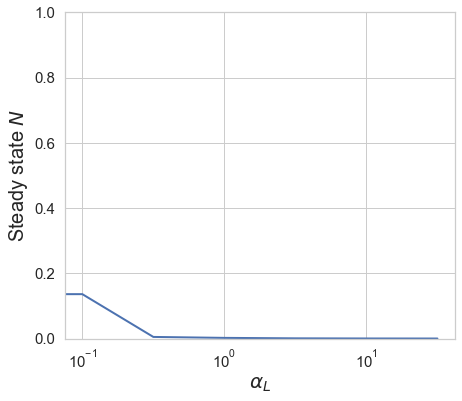

In [24]:
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

Kd_t = 0.1
Kd_c = 0.1
aR = 0.4
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

# Define ligand range for titration- x axis for plot; adding ligands 
aL_vals = np.around(np.logspace(-1, 1.5, num=6, base=10.0), decimals=4)
aL_vals = np.insert(aL_vals, 0, 0)

circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

# Define time series
hr = 48.0 # simulation of 48 hours
interval = 5 # 5 minutes between time steps

convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

# Simulate ligand titration
N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                          hr, interval, convergence_crit)

# Print cis-activation and -inhibition metrics
print('Cis-activation fold-diff:', cis_act)
print('Cis-inhibition efficacy:', cis_inh, '%')

# Added this in to quantify peak width 
for i, element in enumerate(significant_change(aL_vals)):
    if element == 1:
        start_of_peak = aL_vals[i]
        break

for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
    if element == 1:
        end_of_peak = aL_vals[i + 1]
        break

peak_width = end_of_peak - start_of_peak
    
# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

plt.plot(aL_vals, N_vect)
plt.ylabel('Steady state $N$')
plt.xlabel('$\\alpha_L$')
plt.ylim((0,1))
ax.set_xscale('log')
print('start of peak', start_of_peak)
print('end of peak',end_of_peak)
print(peak_width)

In [18]:
np.around(np.linspace(.05, 0.5, num=6), decimals=4)

array([0.05, 0.14, 0.23, 0.32, 0.41, 0.5 ])

Cis-activation fold-diff: 71.72
Cis-inhibition efficacy: 0.0 %


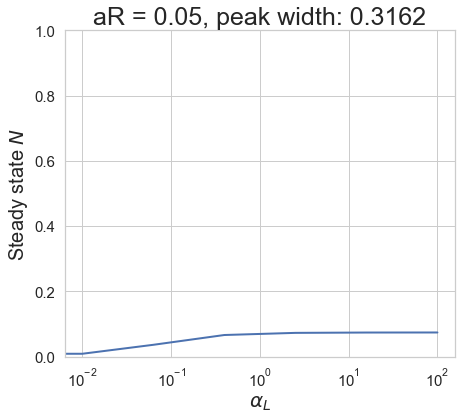

Cis-activation fold-diff: 71.67
Cis-inhibition efficacy: 0.0 %


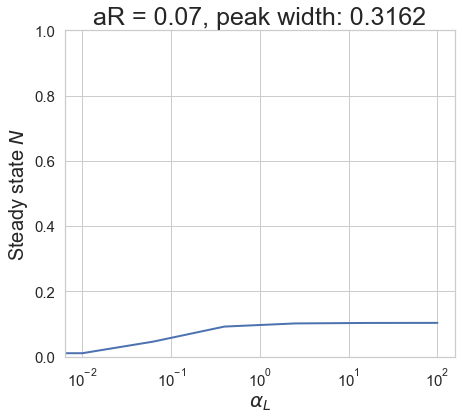

Cis-activation fold-diff: 71.61
Cis-inhibition efficacy: 0.0 %


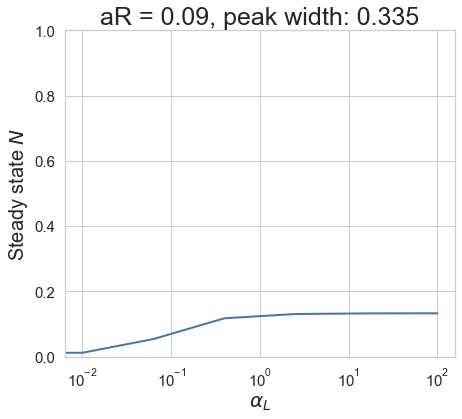

Cis-activation fold-diff: 62.85
Cis-inhibition efficacy: 101.3 %


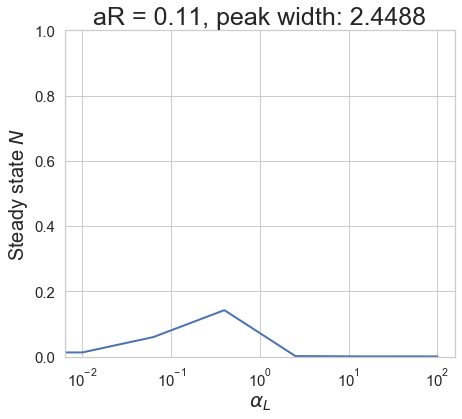

Cis-activation fold-diff: 62.3
Cis-inhibition efficacy: 101.6 %


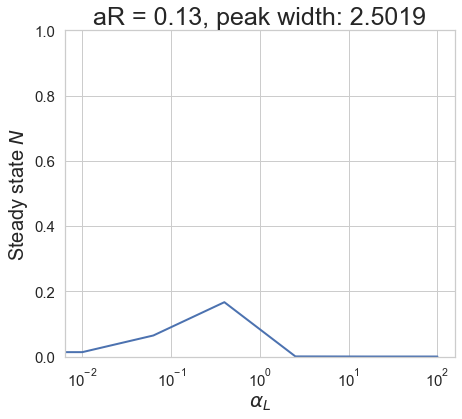

Cis-activation fold-diff: 61.69
Cis-inhibition efficacy: 101.64 %


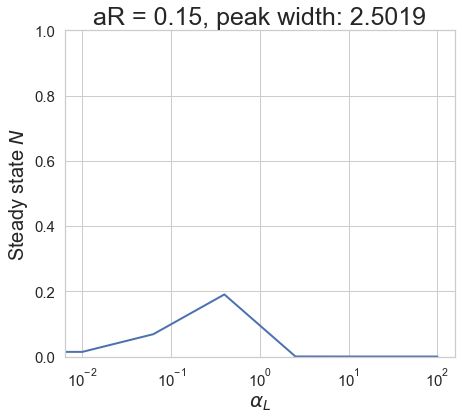

In [25]:
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

Kd_t = 0.1
Kd_c = 0.1
aR_vals = np.around(np.linspace(.05, 0.15, num=6), decimals=4)
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

for aR in aR_vals:
    # Define ligand range for titration- x axis for plot; adding ligands 
    aL_vals = np.around(np.logspace(-2, 2, num=6, base=10.0), decimals=4)
    aL_vals = np.insert(aL_vals, 0, 0)

    circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

    # Define time series
    hr = 48.0 # simulation of 48 hours
    interval = 5 # 5 minutes between time steps

    convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

    # Simulate ligand titration
    N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                              hr, interval, convergence_crit)

    # Print cis-activation and -inhibition metrics
    print('Cis-activation fold-diff:', cis_act)
    print('Cis-inhibition efficacy:', cis_inh, '%')
    
    # Added this in to quantify peak width 
    for i, element in enumerate(significant_change(aL_vals)):
        if element == 1:
            start_of_peak = aL_vals[i]
            break

    for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
        if element == 1:
            end_of_peak = aL_vals[i + 1]
            break

    peak_width = end_of_peak - start_of_peak
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))

    plt.plot(aL_vals, N_vect)
    plt.title('aR = ' + str(aR)+', peak width: '+str(peak_width))
    plt.ylabel('Steady state $N$')
    plt.xlabel('$\\alpha_L$')
    plt.ylim((0,1))
    ax.set_xscale('log')
    plt.show()
    
    

In [ ]:
peakrise = np.max(N_vect)-N_vect[0]
peakrise

In [ ]:
inhibition_drop = np.abs(N_vect[-1]-N_vect[0])
inhibition_drop

In [ ]:
peakrise-inhibition_drop

In [ ]:
aL_vals

In [ ]:
new_array = np.array((aL_vals,N_vect))

In [ ]:
new_array.shape

In [ ]:
index_of_peak = np.argmax(N_vect)

In [ ]:
aL_of_peak = aL_vals[index_of_peak]

In [ ]:
def significant_change(aL_vals):
    new_list = []
    for i, aL in enumerate(aL_vals):
        if (i + 1) <= len(aL_vals) - 1:
            change = N_vect[i + 1] - N_vect[i]
            # print(aL_vals[i])
        if np.abs(change) > 0.05:
            new_list.append(1)
        else:
            new_list.append(0)
    new_array2 = np.array(new_list)
    return new_array2

for i, element in enumerate(significant_change(aL_vals)):
    if element == 1:
        start_of_peak = aL_vals[i]
        
        break
        
for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
    if element == 1:
        end_of_peak = aL_vals[i + 1]
        break
        
peak_width = end_of_peak - start_of_peak # peak width in terms of aL


# Looping through Kd_t Kd_c and aR

In [26]:
def populate_ligand_states(L, C_minus_prev):
    """Computes fraction of free ligand (including protein
    and membrane state) that exists in trans-like vs. cis-
    like state (Lt vs Lc, respectively). This fraction 
    is computed based on a logistic function defined by
    three parameters that you must pass it.
    Returns Lt_tot, Lc_tot."""
    
    max_Lt_frac = 0.4 # 40%
    inflection_pt = .05 # TEMPORARY! MUST CHANGE
    curvature = 5 * (1/inflection_pt) # try 5 * 
    
    frac_Lt = logistic(C_minus_prev, max_Lt_frac, inflection_pt, curvature)
    
    Lt = frac_Lt * L
    Lc = (1 - frac_Lt) * L
    
    return Lt, Lc
    
    # I like the idea of sampling from a binomial distribution, 
    # where theta is returned by the logistic function,
    # but I think it's unnecessarily complicated.
    
    

In [ ]:
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

Kd_t_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
Kd_c_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
aR_vals = np.around(np.linspace(.05, 0.15, num=6), decimals=4) # this range of aR values gives good curve
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

for aR in aR_vals:
    for Kd_t in Kd_t_vals:
        for Kd_c in Kd_c_vals:
            
            # Define ligand range for titration- x axis for plot; adding ligands 
            aL_vals = np.around(np.logspace(-2, 2, num=6, base=10.0), decimals=4)
            aL_vals = np.insert(aL_vals, 0, 0)

            circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

            # Define time series
            hr = 48.0 # simulation of 48 hours
            interval = 5 # 5 minutes between time steps

            convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

            # Simulate ligand titration
            N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                                      hr, interval, convergence_crit)

            # Print cis-activation and -inhibition metrics
            print('Cis-activation fold-diff:', cis_act)
            print('Cis-inhibition efficacy:', cis_inh, '%')

            # Added this in to quantify peak width 
            for i, element in enumerate(significant_change(aL_vals)):
                if element == 1:
                    start_of_peak = i
                    break

            for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
                if element == 1:
                    end_of_peak = i + 1
                    break

            peak_width = end_of_peak - start_of_peak

            # Plot
           
            if (cis_act>1.5) & (cis_inh >90):
                fig, ax = plt.subplots(1, 1, figsize=(7, 6))
                plt.plot(aL_vals, N_vect)
                plt.title('aR = ' + str(aR)+', peak width: '+str(peak_width))
                plt.ylabel('Steady state $N$')
                plt.xlabel('$\\alpha_L$')
                #plt.ylim((0,1))
                ax.set_xscale('log')
                plt.show()
    
    

# Plotting aR, Kd_t, and Kd_c by peak width

In [ ]:
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4
master_array = np.array(())

Kd_t_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
Kd_c_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
aR_vals = np.around(np.linspace(.05, 0.15, num=6), decimals=4) # this range of aR values gives good curve
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

for aR in aR_vals:
    for Kd_t in Kd_t_vals:
        for Kd_c in Kd_c_vals:
            
            # Define ligand range for titration- x axis for plot; adding ligands 
            aL_vals = np.around(np.logspace(-2, 2, num=6, base=10.0), decimals=4)
            aL_vals = np.insert(aL_vals, 0, 0)

            circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

            # Define time series
            hr = 48.0 # simulation of 48 hours
            interval = 5 # 5 minutes between time steps

            convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

            # Simulate ligand titration
            N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                                      hr, interval, convergence_crit)

            # Print cis-activation and -inhibition metrics
            #print('Cis-activation fold-diff:', cis_act)
            #print('Cis-inhibition efficacy:', cis_inh, '%')

            # Added this in to quantify peak width 
            for i, element in enumerate(significant_change(aL_vals)):
                if element == 1:
                    start_of_peak = i
                    break

            for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
                if element == 1:
                    end_of_peak = i + 1
                    break

            peak_width = end_of_peak - start_of_peak
            Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN = circuit_params
            
            create_list = [Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN, cis_act,cis_inh, peak_width]
            
            master_array = np.append(master_array,create_list)
            #print(master_array)
            
            # Plot
            '''
            if (cis_act>1.5) & (cis_inh >90):
                fig, ax = plt.subplots(1, 1, figsize=(7, 6))
                plt.plot(aL_vals, N_vect)
                plt.title('aR = ' + str(aR)+', peak width: '+str(peak_width))
                plt.ylabel('Steady state $N$')
                plt.xlabel('$\\alpha_L$')
                plt.ylim((0,1))
                ax.set_xscale('log')
                plt.show()
            '''

In [ ]:
rows = master_array.size/13

In [ ]:
master_array = master_array.reshape((int(rows),13))

In [ ]:
masterdf = pd.DataFrame(master_array)

In [ ]:
masterdf.columns = ['Kd_t', 'Kd_c', 'aR', 'gR', 'dR', 'gT', 'aL_vals[0]', 'gL', 'gC', 'gN', 'cis_act','cis_inh', 'peak_width']

In [ ]:
masterdf.head()

# when $Kd_t=Kd_c \implies$ larger peak width

# USE HEAT MAPS

In [ ]:
plt.hist(df_subset['aR'],df_subset['peak_width'])

In [ ]:
df_subset = masterdf.loc[(masterdf['Kd_t']==np.around(Kd_t_vals[1],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[1],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='aR',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='aR',
    y='peak_width'
)

bokeh.io.show(p)

print('Kd_t',Kd_t_vals[1])
print('Kd_c',Kd_c_vals[1])

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])


In [ ]:
df_subset = masterdf.loc[(masterdf['Kd_t']==np.around(Kd_t_vals[0],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[1],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='aR',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='aR',
    y='peak_width'
)

bokeh.io.show(p)

print('Kd_t',Kd_t_vals[0])
print('Kd_c',Kd_c_vals[1])

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])

In [ ]:
df_subset = masterdf.loc[(masterdf['Kd_t']==np.around(Kd_t_vals[0],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[0],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='aR',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='aR',
    y='peak_width'
)

bokeh.io.show(p)

print('Kd_t',Kd_t_vals[0])
print('Kd_c',Kd_c_vals[0])

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])

In [ ]:
df_subset = masterdf.loc[(masterdf['Kd_t']==np.around(Kd_t_vals[1],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[0],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='aR',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='aR',
    y='peak_width'
)

bokeh.io.show(p)

print('Kd_t',Kd_t_vals[1])
print('Kd_c',Kd_c_vals[0])

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])

In [ ]:
df_subset = masterdf.loc[(masterdf['aR']==np.around(aR_vals[1],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[1],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='Kd_t',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='Kd_t',
    y='peak_width'
)

bokeh.io.show(p)

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])

Kd_t and Kd_c both showed constant peak width acorss the range I chose

In [ ]:
df_subset

In [ ]:
plt.hist(df_subset.loc[df_subset['aR']==aR_vals[0]]['peak_width'])

In [ ]:
df_subset.loc[df_subset['aR']==aR_vals[0]]['peak_width']

In [ ]:
df_subset